In [147]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


#Visualization Setup
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = (10,10)

In [140]:
#Import data
data = pd.read_excel("IEE520BMI555STUDENTFinalProject2020.xlsx", na_values="None", sheet_name = "labeled")
data.describe()
#data_to_predict = pd.read_excel("IEE520BMI555STUDENTFinalProject2020.xlsx", na_values="None", sheet_name = "unlabeled")

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,y
count,9422.000000,10000.000000,10000.000000,9419.000000,10000.000000,10000.000000,10000.000000,9826.000000,10000.000000,10000.000000,...,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.697410,3.412700,1.081200,4.698163,2.397200,0.447300,0.675200,1.551089,1.501400,1.988700,...,5.930538e+05,31.554800,3267.275700,283.497800,127.355400,2.014869,5.009280,10.032794,7.988933,0.242000
std,1.424695,3.462568,1.191028,2.977955,1.235227,1.193216,0.468323,5.666839,1.123087,1.420273,...,3.342775e+05,8.143539,23103.082676,1281.899531,38.787892,0.991098,0.990554,2.000036,1.603187,0.428316
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.325700e+04,3.000000,0.000000,0.000000,3.000000,-1.884801,1.450000,2.900000,2.360000,0.000000
25%,0.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,3.653175e+05,28.000000,0.000000,0.000000,126.000000,1.345720,4.340000,8.690000,6.910000,0.000000
50%,0.000000,3.000000,1.000000,4.000000,2.000000,0.000000,1.000000,0.000000,2.000000,2.000000,...,5.570185e+05,31.000000,0.000000,0.000000,126.000000,2.014534,5.010000,10.040000,7.980000,0.000000
75%,1.000000,4.000000,2.000000,7.000000,3.000000,0.000000,1.000000,0.000000,3.000000,3.000000,...,7.416855e+05,38.000000,0.000000,0.000000,141.000000,2.695249,5.680000,11.390000,9.070000,0.000000
max,7.000000,15.000000,6.000000,12.000000,5.000000,4.000000,1.000000,40.000000,3.000000,4.000000,...,4.291793e+06,50.000000,314156.000000,12252.000000,311.000000,5.664434,8.900000,18.460000,13.820000,1.000000


In [141]:
# Separate data into X and y for training and validation
X, y = data.iloc[:,:-1],data.iloc[:,-1]
#same process for the predction data
X_to_predict = data_to_predict.iloc[:,1:-1]


In [149]:
# Random Oversampling
y_0_count, y_1_count = data['y'].value_counts()

y_0 = data[data['y'] == 0]
y_1 = data[data['y'] == 1]

y_1_over = y_1.sample(y_0_count, replace=True)

# incorporating oversampled y's into all data
data_oversampled = y_0.append(y_1_over,ignore_index=True)

# Separate data into X and y for training and validation
X, y = data_oversampled.iloc[:,:-1],data_oversampled.iloc[:,-1]

In [142]:
# Separate categorical features from variable features
X_cat = X.iloc[:,0:12]
X_var = X.iloc[:,13:]

# same process for the prediction data
X_to_predict_cat = X_to_predict.iloc[:,0:12]
X_to_predict_var = X_to_predict.iloc[:,13:]


In [143]:
# Appending all data to potentially use KNN imputer later
all_xs = X.append(X_to_predict,ignore_index=True)
all_xs.describe()

# after usign the KNN Imputer saparate each Xs and remember to round

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22
count,14142.000000,15000.000000,15000.000000,14138.000000,15000.000000,15000.000000,15000.000000,14734.000000,15000.000000,15000.000000,...,15000.00000,1.500000e+04,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,0.699406,3.380733,1.079400,4.683831,2.395800,0.454400,0.674933,1.538754,1.501600,1.993733,...,121.64920,5.941604e+05,31.52400,3193.379267,281.263533,127.470333,2.016296,5.005552,10.022228,7.985307
std,1.426491,3.429309,1.196101,2.972210,1.235817,1.205827,0.468415,5.670429,1.119262,1.413021,...,43.02516,3.298171e+05,8.08529,22375.375096,1274.374452,38.522990,0.994001,0.990467,2.005221,1.598726
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,53.00000,4.325700e+04,3.00000,0.000000,0.000000,3.000000,-1.884801,1.450000,1.770000,2.360000
25%,0.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,88.00000,3.690718e+05,28.00000,0.000000,0.000000,126.000000,1.340325,4.330000,8.670000,6.910000
50%,0.000000,3.000000,1.000000,4.000000,2.000000,0.000000,1.000000,0.000000,2.000000,2.000000,...,116.00000,5.589255e+05,31.00000,0.000000,0.000000,126.000000,2.014116,5.000000,10.020000,7.970000
75%,1.000000,4.000000,2.000000,7.000000,3.000000,0.000000,1.000000,0.000000,2.000000,3.000000,...,151.00000,7.422990e+05,38.00000,0.000000,0.000000,141.000000,2.695249,5.680000,11.380000,9.060000
max,7.000000,15.000000,6.000000,13.000000,5.000000,4.000000,1.000000,40.000000,3.000000,4.000000,...,283.00000,4.291793e+06,50.00000,314156.000000,12252.000000,311.000000,5.853367,8.900000,18.460000,13.820000


,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,1,2,8,1,0,0,0,3,0,4,6
1,12,0,2,0,0,0,0,3,3,9,4
2,0,0,3,2,0,1,0,0,3,0,4
3,3,2,2,1,0,0,0,1,0,2,4
4,6,2,4,3,0,1,0,1,3,5,7


In [150]:
#Split Data 80/20
seed = 519
x_train, x_val, y_train, y_val = train_test_split(X,y, test_size= 0.20, random_state=seed)

In [153]:
#Train a quick xgb classifier
xgb_model = XGBClassifier().fit(x_train, y_train)

Balanced Accuracy:  0.9100883149808117
[[1290  194]
 [  76 1472]]


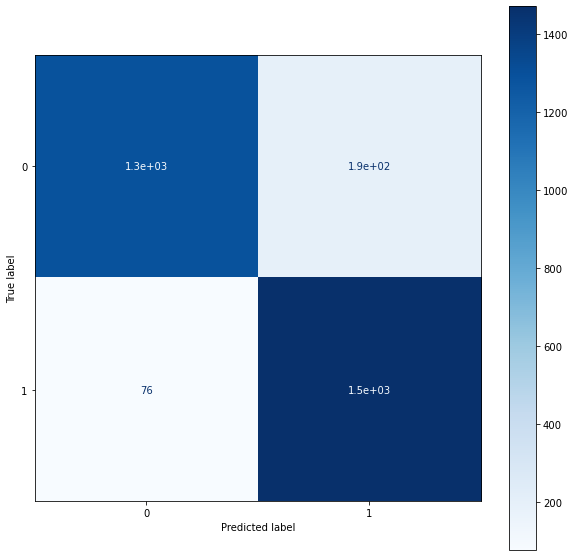

In [154]:
y_hat = xgb_model.predict(x_val)
print("Balanced Accuracy: ", metrics.balanced_accuracy_score(y_val, y_hat))
plot_confusion_matrix(xgb_model,x_val,y_val, cmap=plt.cm.Blues)
print(confusion_matrix(y_val,y_hat))

In [155]:
#Train the final xgb classifier
xgb_final_model = XGBClassifier(nthread=4,seed = seed)

parameters = {
    'n_estimators': range(100, 1000,100),
    'learning_rate': [0.1, 0.01, 0.05] }

grid_search = GridSearchCV(
    estimator=xgb_final_model,
    param_grid=parameters,
    scoring = 'balanced_accuracy',
    n_jobs = 4,
    cv = 5,
    verbose=True
)

grid_search.fit(X, y)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:  7.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=519, subsample=None, tree_method=None,
                                     validate_paramet

In [160]:
grid_search.best_score_

0.9354221635883906

In [158]:
#predict the final data:
xgb_final_model = XGBClassifier(nthread=4,seed = seed, n_estimators=900, learning_rate = 0.1).fit(X, y)

y_hat_final = xgb_final_model.predict(X_to_predict)

y_hat_final =  pd.DataFrame(y_hat_final, columns=['y'])

In [159]:
#combining dataframes to print final results
y_to_print = data_to_predict.iloc[:,0:1]
y_to_print = pd.concat([y_to_print, y_hat_final], axis = 1, sort = False)
y_to_print.to_csv('IEE520BMI555Report2020JavierLeonMendez.csv', index = False)

